In [89]:
import pandas as pd
import numpy as np

# FTHG = Full Time Home Team Goals
# FTAG = Full Time Away Team Goals
# FTR = Full Time Result (H=Home Win, D=Draw, A=Away Win)

fields = ["Date", "HomeTeam", "AwayTeam", "FTHG", "FTAG", "FTR"]

df = pd.read_csv("data/Ligue1_game_stats.csv", usecols = fields)
df['Date'] = pd.to_datetime(df['Date'])

# Rename the columns for clarity: 
df = df.rename(columns={'FTHG': 'Home_goals', 'FTAG': 'Away_goals', 'FTR': 'Result'})
# Home_goals = Full Time Home Team Goals
# Away_goals = Full Time Away Team Goals
# Result = Full Time Result (H=Home Win, D=Draw, A=Away Win)


df.head()


/var/folders/42/4qk9d5xn1zb22gk9hbqpxdwh0000gn/T/ipykernel_55971/3495449552.py:11: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['Date'] = pd.to_datetime(df['Date'])


,Date,HomeTeam,AwayTeam,Home_goals,Away_goals,Result
0,2025-08-15,Rennes,Marseille,1,0,H
1,2025-08-16,Lens,Lyon,0,1,A
2,2025-08-16,Monaco,Le Havre,3,1,H
3,2025-08-16,Nice,Toulouse,0,1,A
4,2025-08-17,Brest,Lille,3,3,D


In [90]:
# Dataset with only Marseille games

df_om_games = df[(df["HomeTeam"] == "Marseille") | (df["AwayTeam"] == "Marseille")].copy()


df_om_games.head()

df_om_games["OM_goals_scored"] = np.where(df_om_games['HomeTeam'] == 'Marseille', df_om_games["Home_goals"], df_om_games["Away_goals"])
df_om_games["OM_goals_conceded"] = np.where(df_om_games['HomeTeam'] == 'Marseille', df_om_games["Away_goals"], df_om_games["Home_goals"])
df_om_games["is_OM_win"] = np.where(df_om_games['HomeTeam'] == 'Marseille', df_om_games["Result"] == "H", df_om_games["Result"] == "A")
df_om_games["is_Draw"] = df_om_games["Result"] == "D"


df_om_games.head(10)

df_om_games = df_om_games.assign(goals_scored_last_3_games=lambda d: d["OM_goals_scored"].rolling(3).sum().shift())
df_om_games = df_om_games.assign(goals_conceded_last_3_games=lambda d: d["OM_goals_conceded"].rolling(3).sum().shift())

df_om_games

,Date,HomeTeam,AwayTeam,Home_goals,Away_goals,Result,OM_goals_scored,OM_goals_conceded,is_OM_win,is_Draw,goals_scored_last_3_games,goals_conceded_last_3_games
0,2025-08-15,Rennes,Marseille,1,0,H,0,1,False,False,NaN,NaN
10,2025-08-23,Marseille,Paris FC,5,2,H,5,2,True,False,NaN,NaN
26,2025-08-31,Lyon,Marseille,1,0,H,0,1,False,False,NaN,NaN
27,2025-09-12,Marseille,Lorient,4,0,H,4,0,True,False,5.0,4.0
44,2025-09-22,Marseille,Paris SG,1,0,H,1,0,True,False,9.0,3.0
45,2025-09-26,Strasbourg,Marseille,1,2,A,2,1,True,False,5.0,1.0
55,2025-10-04,Metz,Marseille,0,3,A,3,0,True,False,7.0,1.0
66,2025-10-18,Marseille,Le Havre,6,2,H,6,2,True,False,6.0,1.0
75,2025-10-25,Lens,Marseille,2,1,H,1,2,False,False,11.0,3.0
85,2025-10-29,Marseille,Angers,2,2,D,2,2,False,True,10.0,4.0


# Construction of a model for the 2024-2025 season


In [91]:
# Loading the data of the previous year for training the model. 
df_2024 = pd.read_csv("data/Ligue1_2024-2025.csv", usecols = fields)
df['Date'] = pd.to_datetime(df['Date'])

# Rename the columns for clarity: 
df_2024 = df_2024.rename(columns={'FTHG': 'Home_goals', 'FTAG': 'Away_goals', 'FTR': 'Result'})

df_2024.columns

Index(['Date', 'HomeTeam', 'AwayTeam', 'Home_goals', 'Away_goals', 'Result'], dtype='object')

## Creating an ELO score, which compute a rank of the teams using a numerical score

In [92]:
# Defining the ELO function: 
import pandas as pd
import numpy as np

def expected_score(rating_A, rating_B):
    """Odds that A wins against B"""
    return 1 / (1 + 10 ** ((rating_B - rating_A) / 400))

def update_elo(rating_A, rating_B, score_A, K=30):
    """
    Update Elo ratings after a match
    score_A : 1 = A wins, 0.5 = draw, 0 = A loses
    We chose K=30 as of now based on common practice for this hyper_parameter in football 
    """
    
    expected_A = expected_score(rating_A, rating_B)
    expected_B = 1 - expected_A
    
    new_rating_A = round(rating_A + K * (score_A - expected_A),0)
    new_rating_B = round(rating_B + K * ((1 - score_A) - expected_B),0)
    
    return new_rating_A, new_rating_B


In [93]:

# Implementation to the 2024 dataset

# Initialisation
teams = pd.concat([df_2024['HomeTeam']]).unique()
elo = {team: 1500 for team in teams}  # Initial score
elo_A, elo_B = [], []

# Iteration
for i, row in df_2024.iterrows():
    team_A, team_B = row['HomeTeam'], row['AwayTeam']
    res = row['Result']

    # Results
    if res == 'H': score_A, score_B = 1, 0
    elif res == 'A': score_A, score_B = 0, 1
    else: score_A, score_B = 0.5, 0.5
    
    # Save before update
    elo_A.append(elo[team_A])
    elo_B.append(elo[team_B])
    
    # Update
    new_A, new_B = update_elo(elo[team_A], elo[team_B], score_A)
    elo[team_A], elo[team_B] = new_A, new_B

print(elo_A)
df_2024['Elo_Home'] = elo_A
df_2024['Elo_Away'] = elo_B
df_2024['Diff_Elo'] = df_2024['Elo_Home'] - df_2024['Elo_Away']




[1500, 1500, 1500, 1500, 1500, 1500, 1500, 1500, 1500, 1515.0, 1485.0, 1515.0, 1485.0, 1515.0, 1500.0, 1485.0, 1500.0, 1515.0, 1471.0, 1471.0, 1486.0, 1499.0, 1529.0, 1471.0, 1500.0, 1486.0, 1529.0, 1455.0, 1528.0, 1484.0, 1544.0, 1483.0, 1530.0, 1499.0, 1485.0, 1529.0, 1486.0, 1496.0, 1498.0, 1518.0, 1542.0, 1459.0, 1473.0, 1457.0, 1490.0, 1455.0, 1555.0, 1526.0, 1486.0, 1555.0, 1485.0, 1461.0, 1512.0, 1497.0, 1538.0, 1461.0, 1511.0, 1486.0, 1492.0, 1473.0, 1532.0, 1514.0, 1501.0, 1579.0, 1488.0, 1476.0, 1565.0, 1456.0, 1456.0, 1494.0, 1457.0, 1449.0, 1475.0, 1453.0, 1525.0, 1538.0, 1521.0, 1438.0, 1504.0, 1501.0, 1545.0, 1559.0, 1542.0, 1592.0, 1504.0, 1448.0, 1471.0, 1477.0, 1429.0, 1479.0, 1544.0, 1498.0, 1510.0, 1487.0, 1536.0, 1444.0, 1409.0, 1473.0, 1520.0, 1553.0, 1614.0, 1523.0, 1453.0, 1504.0, 1541.0, 1510.0, 1453.0, 1536.0, 1505.0, 1447.0, 1460.0, 1624.0, 1413.0, 1447.0, 1532.0, 1492.0, 1542.0, 1547.0, 1508.0, 1549.0, 1533.0, 1477.0, 1523.0, 1444.0, 1456.0, 1451.0, 1495.0, 1

In [94]:
# Verification
elo_rank = {k: v for k, v in sorted(elo.items(), key=lambda item: item[1])}
print(elo_rank)
print(df_2024)

{'Montpellier': 1302.0, 'Reims': 1405.0, 'St Etienne': 1413.0, 'Angers': 1438.0, 'Le Havre': 1448.0, 'Nantes': 1454.0, 'Rennes': 1461.0, 'Toulouse': 1474.0, 'Auxerre': 1478.0, 'Brest': 1512.0, 'Lens': 1523.0, 'Lyon': 1551.0, 'Lille': 1564.0, 'Monaco': 1566.0, 'Strasbourg': 1572.0, 'Nice': 1577.0, 'Marseille': 1579.0, 'Paris SG': 1683.0}
           Date    HomeTeam     AwayTeam  Home_goals  Away_goals Result  \
0    16/08/2024    Le Havre     Paris SG           1           4      A   
1    17/08/2024       Brest    Marseille           1           5      A   
2    17/08/2024       Reims        Lille           0           2      A   
3    17/08/2024      Monaco   St Etienne           1           0      H   
4    18/08/2024     Auxerre         Nice           2           1      H   
..          ...         ...          ...         ...         ...    ...   
301  17/05/2025      Nantes  Montpellier           3           0      H   
302  17/05/2025        Nice        Brest           6         

## Features engeneering

In [95]:
# Compute current form of the teams

# Initialisation
teams = pd.concat([df_2024['HomeTeam']]).unique()
perf_last_3_games = {team: 0 for team in teams} # Number of points won in the last 3 games
perf_A, perf_B = [], []
memory = {team: [0,0,0] for team in teams}

# Iteration
for i, row in df_2024.iterrows():
    team_A, team_B = row['HomeTeam'], row['AwayTeam']
    res = row['Result']

    # Results
    if res == 'H': score_A, score_B = 3, 0
    elif res == 'A': score_A, score_B = 0, 3
    else: score_A, score_B = 1, 1

    # Save before update
    perf_A.append(perf_last_3_games[team_A])
    perf_B.append(perf_last_3_games[team_B])
    
    # Update memory
    memory[team_A]=(memory[team_A][1:])
    memory[team_A].append(score_A)
    memory[team_B]=(memory[team_B][1:])
    memory[team_B].append(score_B)

    # Update perf
    perf_last_3_games[team_A] = sum(memory[team_A])
    perf_last_3_games[team_B] = sum(memory[team_B])

df_2024['current_form_Home'] = perf_A
df_2024['current_form_Away'] = perf_B

**This code does not work** , I'll fix it later

In [96]:
# Compute recent goals scored and conceded for each team

matches_2024 = df_2024.copy()  # rename to avoid conflict

# Home perspective
home_df = matches_2024[["Date", "HomeTeam", "Home_goals", "Away_goals"]].copy()
home_df.rename(columns={
    "HomeTeam": "Team",
    "Home_goals": "goals_scored",
    "Away_goals": "goals_conceded"
}, inplace=True)

# Away perspective
away_df = matches_2024[["Date", "AwayTeam", "Away_goals", "Home_goals"]].copy()
away_df.rename(columns={
    "AwayTeam": "Team",
    "Away_goals": "goals_scored",
    "Home_goals": "goals_conceded"
}, inplace=True)

# Combine both perspectives
team_df = pd.concat([home_df, away_df], ignore_index=True)
team_df.sort_values(["Team", "Date"], inplace=True)

# Rolling stats per team
team_df["goals_scored_last_3"] = team_df.groupby("Team")["goals_scored"].rolling(3).sum().shift().reset_index(level=0, drop=True)
team_df["goals_conceded_last_3"] = team_df.groupby("Team")["goals_conceded"].rolling(3).sum().shift().reset_index(level=0, drop=True)

# Merge back to original matches_2024
matches_2024 = matches_2024.merge(
    team_df[["Date", "Team", "goals_scored_last_3", "goals_conceded_last_3"]].rename(columns={
        "Team": "HomeTeam",
        "goals_scored_last_3": "Home_goals_scored_last_3",
        "goals_conceded_last_3": "Home_goals_conceded_last_3"
    }),
    on=["Date", "HomeTeam"],
    how="left"
)

matches_2024 = matches_2024.merge(
    team_df[["Date", "Team", "goals_scored_last_3", "goals_conceded_last_3"]].rename(columns={
        "Team": "AwayTeam",
        "goals_scored_last_3": "Away_goals_scored_last_3",
        "goals_conceded_last_3": "Away_goals_conceded_last_3"
    }),
    on=["Date", "AwayTeam"],
    how="left"
)


In [97]:
pd.unique(matches_2024["HomeTeam"])


array(['Le Havre', 'Brest', 'Reims', 'Monaco', 'Auxerre', 'Angers',
       'Montpellier', 'Toulouse', 'Rennes', 'Paris SG', 'Lyon', 'Lille',
       'St Etienne', 'Lens', 'Nantes', 'Nice', 'Strasbourg', 'Marseille'],
      dtype=object)

In [98]:
# adding the number of rest days for each team before game 

teams = [
    "Angers",
    "Auxerre",
    "Brest",
    "Le Havre",
    "Lens",
    "Lille",
    "Lyon",
    "Marseille",
    "Monaco",
    "Montpellier",
    "Nantes",
    "Nice",
    "Paris SG",
    "Reims",
    "Rennes",
    "St Etienne",
    "Strasbourg",
    "Toulouse"
]

frames = []

for team in teams:
    df_temp = pd.read_csv(f"data/{team}_matches_with_rest_days_2024.csv")
    frames.append(df_temp)

df_rest_days_all_teams = pd.concat(frames)

# reset the index to avoid duplicate indices after the concat
df_rest_days_all_teams = df_rest_days_all_teams.reset_index(drop=True)

# Create a new empty dataframe for matches
match_df = pd.DataFrame(columns=['date', 'home_team', 'away_team', 'home_team_rest_days', 'away_team_rest_days'])

# Group matches by date and process each match
processed_matches = set() 

for _, row in df_rest_days_all_teams.iterrows():
    date = row['date']
    team = row['team']
    opponent = row['opponent']
    venue = row['venue_team']
    rest_days = row['rest_days_team']
    
    # Create a unique match identifier (ordered team names to avoid duplicates)
    match_id = tuple(sorted([team, opponent]) + [date])
    
    # Skip if we already processed this match
    if match_id in processed_matches:
        continue
    
    # Find the corresponding row for the opponent
    opponent_rows = df_rest_days_all_teams[
        (df_rest_days_all_teams['date'] == date) & 
        (df_rest_days_all_teams['team'] == opponent) & 
        (df_rest_days_all_teams['opponent'] == team)
    ]
    
    # If we found the opponent row, add this match to our new dataframe
    if len(opponent_rows) > 0:
        opponent_row = opponent_rows.iloc[0]
        opponent_rest_days = opponent_row['rest_days_team']
        
        # Determine which team is home and which is away
        if venue == 'Home':
            home_team, away_team = team, opponent
            home_rest_days, away_rest_days = rest_days, opponent_rest_days
        else:
            home_team, away_team = opponent, team
            home_rest_days, away_rest_days = opponent_rest_days, rest_days
        
        # Add to the match dataframe
        match_df.loc[len(match_df)] = [date, home_team, away_team, home_rest_days, away_rest_days]
        
        # Mark this match as processed
        processed_matches.add(match_id)



print(match_df.info())


<class 'pandas.core.frame.DataFrame'>
Index: 315 entries, 0 to 314
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   date                 315 non-null    object
 1   home_team            315 non-null    object
 2   away_team            315 non-null    object
 3   home_team_rest_days  315 non-null    int64 
 4   away_team_rest_days  315 non-null    int64 
dtypes: int64(2), object(3)
memory usage: 14.8+ KB
None


In [99]:
# Merging datasets to have all interesting variables together
match_df = match_df.rename(columns = {"date" : "Date", "home_team" : "HomeTeam", "away_team" : "AwayTeam"})
match_df["Date"] = pd.to_datetime(match_df["Date"])
df_2024["Date"] = pd.to_datetime(df_2024["Date"])

df_2024 = pd.merge(df_2024, match_df, how = "left", on = ["Date", "HomeTeam", "AwayTeam"])

df_2024.sample(13)


/var/folders/42/4qk9d5xn1zb22gk9hbqpxdwh0000gn/T/ipykernel_55971/558194231.py:4: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df_2024["Date"] = pd.to_datetime(df_2024["Date"])


,Date,HomeTeam,AwayTeam,Home_goals,Away_goals,Result,Elo_Home,Elo_Away,Diff_Elo,current_form_Home,current_form_Away,home_team_rest_days,away_team_rest_days
207,2025-02-28,Monaco,Reims,3,0,H,1533.0,1412.0,121.0,3,0,6,3
258,2025-04-13,Le Havre,Rennes,1,5,A,1429.0,1450.0,-21.0,6,3,7,7
94,2024-11-10,Nice,Lille,2,2,D,1536.0,1541.0,-5.0,7,5,3,5
152,2025-01-12,Paris SG,St Etienne,2,1,H,1637.0,1445.0,192.0,7,3,7,8
303,2025-05-17,Paris SG,Auxerre,3,1,H,1676.0,1485.0,191.0,3,4,7,7
168,2025-01-26,Nantes,Lyon,1,1,D,1453.0,1537.0,-84.0,3,4,7,3
102,2024-11-23,St Etienne,Montpellier,1,0,H,1453.0,1427.0,26.0,3,3,13,13
304,2025-05-17,St Etienne,Toulouse,2,3,A,1427.0,1460.0,-33.0,3,5,7,7
233,2025-03-16,Paris SG,Marseille,3,1,H,1699.0,1570.0,129.0,9,3,5,8
112,2024-12-01,Montpellier,Lille,2,2,D,1413.0,1553.0,-140.0,3,5,8,4


## First training not especially on OM, but for all teams

**ATTENTION**: We have Nans in the goals: I drop them for now, we'll se how we can handle them

Update: We don't use goals as of now, so no need

In [100]:
# Drop the Nan
#df_2024.isna().sum()
#df_2024_clean = df_2024.dropna()
#df_2024_clean.isna().sum()
#df_2024_clean.columns


In [101]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier

features = ['Elo_Home', 'Elo_Away', 'Diff_Elo', 'current_form_Home','current_form_Away']

X = df_2024[features]
y = df_2024['Result']

tscv = TimeSeriesSplit(n_splits=5) #We use TimeSeriesSplit for defining the different sample in order to avoid training the model with data posterior to the test dataset.
model = RandomForestClassifier()

for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(model.score(X_test, y_test))

importances = model.feature_importances_
feature_importance_dict = dict(zip(features, importances))
print(feature_importance_dict)

0.5098039215686274
0.47058823529411764
0.49019607843137253
0.5490196078431373
0.43137254901960786
{'Elo_Home': np.float64(0.25872612885380414), 'Elo_Away': np.float64(0.24300864455739482), 'Diff_Elo': np.float64(0.25850245873979244), 'current_form_Home': np.float64(0.11100407554092666), 'current_form_Away': np.float64(0.12875869230808204)}


The results are insanely bad. Cannot get worse at least

## Model for OM 2024

### Data preprocessing with only Marseille's game :

In [136]:
# Creating the data set with only OM matches
df_om_games_2024 = df_2024[(df_2024["HomeTeam"] == "Marseille") | (df_2024["AwayTeam"] == "Marseille")].copy()

# Compute the feature from the Marseille point of view
df_om_games_2024["OM_goals_scored"] = np.where(df_om_games_2024['HomeTeam'] == 'Marseille', df_om_games_2024["Home_goals"], df_om_games_2024["Away_goals"])
df_om_games_2024["OM_goals_conceded"] = np.where(df_om_games_2024['HomeTeam'] == 'Marseille', df_om_games_2024["Away_goals"], df_om_games_2024["Home_goals"])
df_om_games_2024["Current_form_OM"] = np.where(df_om_games_2024['HomeTeam'] == 'Marseille', df_om_games_2024["current_form_Home"], df_om_games_2024["current_form_Away"])
df_om_games_2024["Current_form_Opponent"] = np.where(df_om_games_2024['HomeTeam'] == 'Marseille', df_om_games_2024["current_form_Away"], df_om_games_2024["current_form_Home"])
df_om_games_2024["is_OM_win"] = np.where(df_om_games_2024['HomeTeam'] == 'Marseille', 1 * (df_om_games_2024["Result"] == "H"), 1 * (df_om_games_2024["Result"] == "A"))
df_om_games_2024["ELO OM"] = np.where(df_om_games_2024['HomeTeam'] == 'Marseille', df_om_games_2024["Elo_Home"], df_om_games_2024["Elo_Away"])
df_om_games_2024["ELO Opponent"] = np.where(df_om_games_2024['HomeTeam'] == 'Marseille', df_om_games_2024["Elo_Away"], df_om_games_2024["Elo_Home"])
df_om_games_2024["OM_at_home"] = 1 * (df_2024["HomeTeam"] == "Marseille")
df_om_games_2024 = df_om_games_2024.assign(OM_goals_scored_last_3_games=lambda d: d["OM_goals_scored"].rolling(3, min_periods = 1).sum().shift())
df_om_games_2024 = df_om_games_2024.assign(OM_goals_conceded_last_3_games=lambda d: d["OM_goals_conceded"].rolling(3, min_periods = 1).sum().shift())
df_om_games_2024['rest_days_OM'] = np.where(df_om_games_2024['HomeTeam'] == 'Marseille', df_om_games_2024["home_team_rest_days"], df_om_games_2024["away_team_rest_days"])
df_om_games_2024['rest_days_Opponent'] = np.where(df_om_games_2024['HomeTeam'] == 'Marseille', df_om_games_2024["away_team_rest_days"], df_om_games_2024["home_team_rest_days"])

# Drop useless columns
X_OM_2024 = df_om_games_2024.drop(columns= ['HomeTeam', 'current_form_Home','home_team_rest_days','away_team_rest_days',
       'current_form_Away', 'AwayTeam', 'Home_goals', 'Away_goals', 'Result', 'Elo_Home', 'Elo_Away',
        'Diff_Elo', 'OM_goals_scored', 'OM_goals_conceded']).copy()

X_OM_2024

,Date,Current_form_OM,Current_form_Opponent,is_OM_win,ELO OM,ELO Opponent,OM_at_home,OM_goals_scored_last_3_games,OM_goals_conceded_last_3_games,rest_days_OM,rest_days_Opponent
1,2024-08-17,0,0,1,1500.0,1500.0,0,NaN,NaN,0,0
17,2024-08-25,3,0,0,1515.0,1485.0,1,5.0,1.0,8,8
21,2024-08-31,4,2,1,1514.0,1499.0,0,7.0,3.0,6,6
28,2024-09-14,7,4,1,1528.0,1500.0,1,10.0,4.0,14,13
44,2024-09-22,7,4,1,1542.0,1490.0,0,7.0,3.0,8,7
53,2024-09-29,9,2,0,1555.0,1497.0,0,8.0,3.0,7,8
54,2024-10-04,6,2,0,1538.0,1449.0,1,5.0,3.0,5,5
71,2024-10-20,4,3,1,1534.0,1449.0,0,4.0,4.0,16,14
80,2024-10-27,4,7,0,1545.0,1578.0,1,6.0,2.0,7,5
89,2024-11-03,4,1,1,1531.0,1479.0,0,6.0,4.0,7,7


In [137]:
# Drop the Nan
print(X_OM_2024.isna().sum())
X_OM_2024_clean = X_OM_2024.dropna().copy()
print(X_OM_2024_clean.isna().sum())

Date                              0
Current_form_OM                   0
Current_form_Opponent             0
is_OM_win                         0
ELO OM                            0
ELO Opponent                      0
OM_at_home                        0
OM_goals_scored_last_3_games      1
OM_goals_conceded_last_3_games    1
rest_days_OM                      0
rest_days_Opponent                0
dtype: int64
Date                              0
Current_form_OM                   0
Current_form_Opponent             0
is_OM_win                         0
ELO OM                            0
ELO Opponent                      0
OM_at_home                        0
OM_goals_scored_last_3_games      0
OM_goals_conceded_last_3_games    0
rest_days_OM                      0
rest_days_Opponent                0
dtype: int64


### Quick EDA

<Axes: xlabel='is_OM_win'>

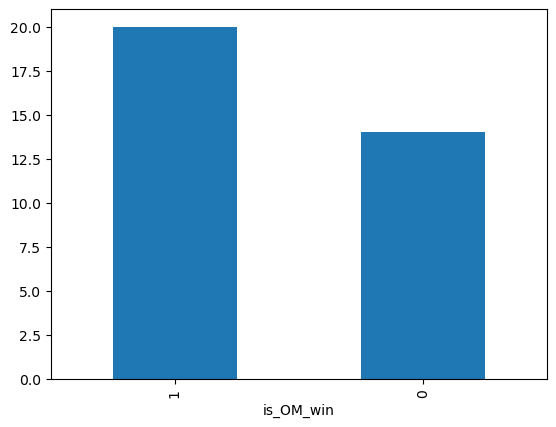

In [138]:
df_om_games_2024['is_OM_win'].value_counts().plot.bar()

array([[<Axes: title={'center': 'Current_form_OM'}>,
        <Axes: title={'center': 'Current_form_Opponent'}>,
        <Axes: title={'center': 'ELO OM'}>],
       [<Axes: title={'center': 'ELO Opponent'}>,
        <Axes: title={'center': 'OM_goals_scored_last_3_games'}>,
        <Axes: title={'center': 'OM_goals_conceded_last_3_games'}>],
       [<Axes: title={'center': 'rest_days_OM'}>,
        <Axes: title={'center': 'rest_days_Opponent'}>, <Axes: >]],
      dtype=object)

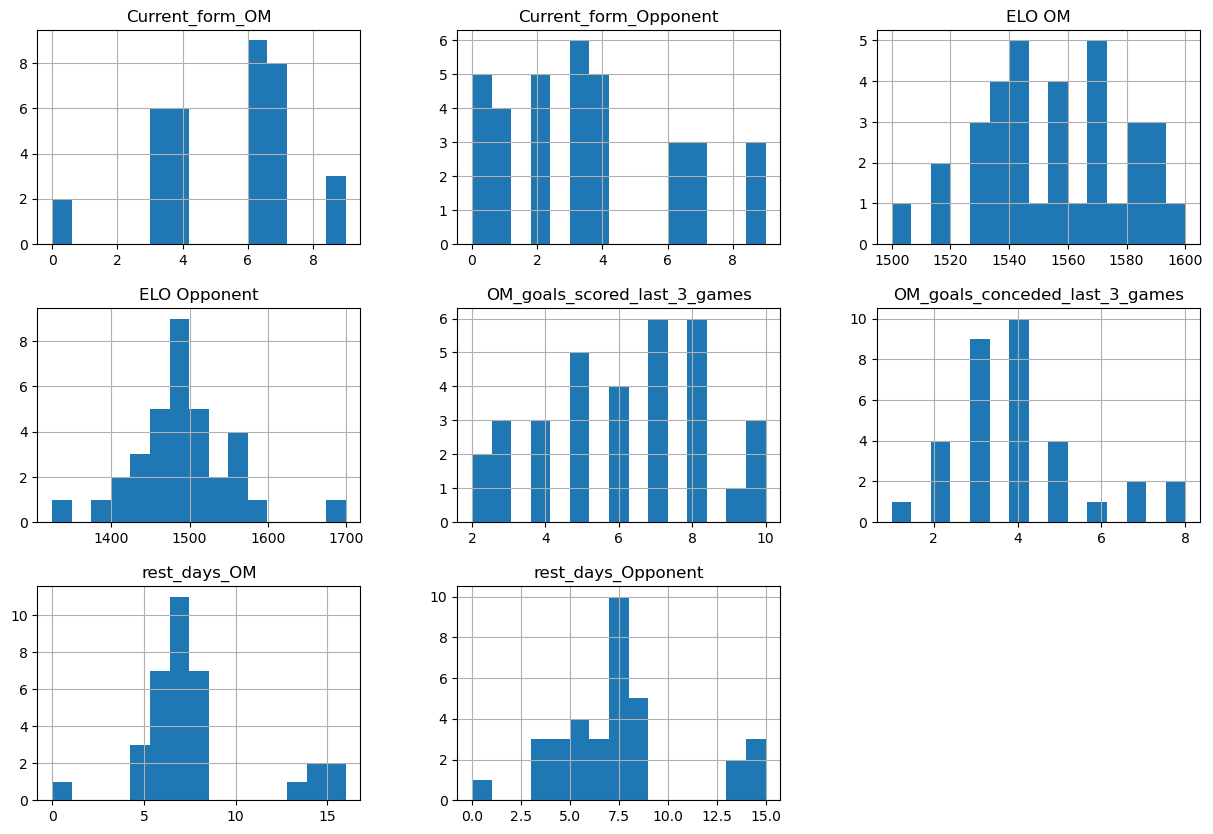

In [139]:
numeric_features = ['Current_form_OM','Current_form_Opponent',
                    'ELO OM','ELO Opponent',
                    'OM_goals_scored_last_3_games','OM_goals_conceded_last_3_games',
                    'rest_days_OM','rest_days_Opponent']

df_om_games_2024[numeric_features].hist(bins=15, figsize=(15,10))


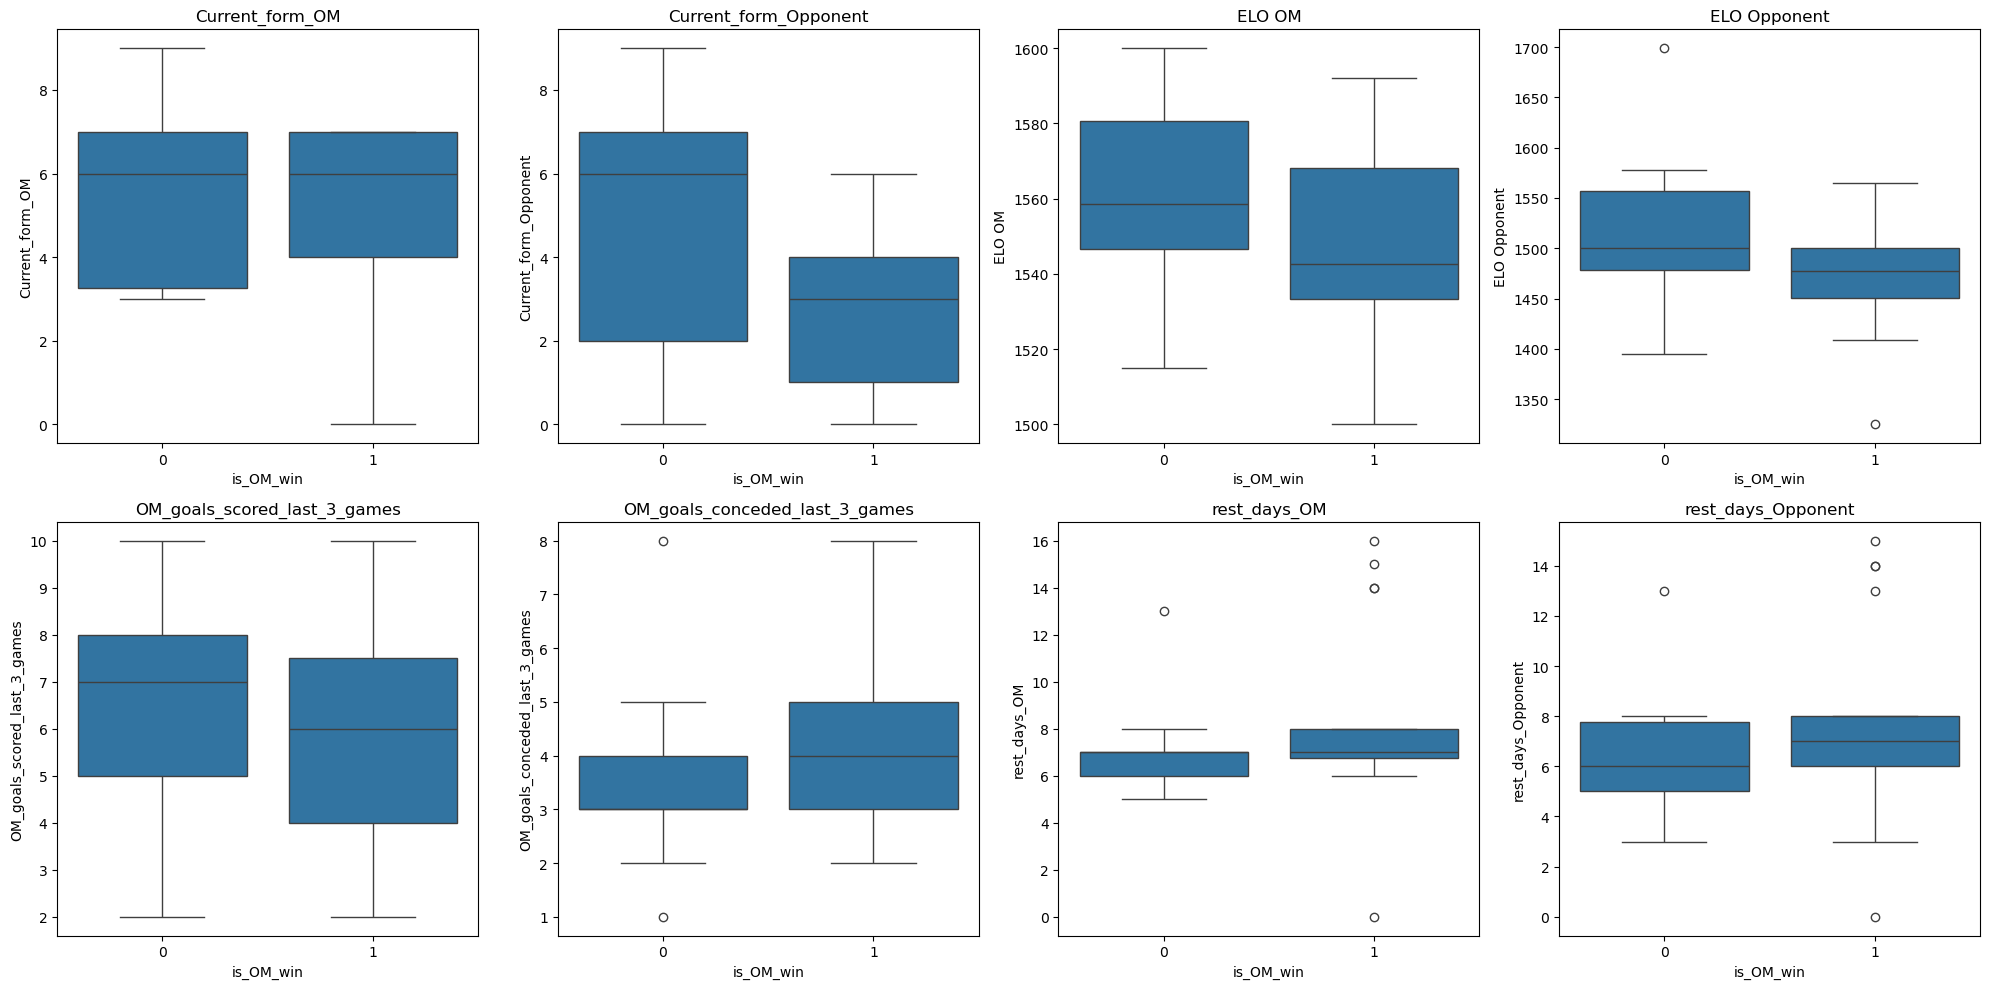

In [140]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

for i, col in enumerate(numeric_features):
    sns.boxplot(x='is_OM_win', y=col, data=df_om_games_2024, ax=axes[i])
    axes[i].set_title(col)

plt.tight_layout()
plt.show()


### First training using Logistic regression

In [184]:
# A few more preprocessing in order to get a more stable model
X_OM_2024_clean.columns
X_OM_2024_clean['Delta_current_form'] = X_OM_2024_clean['Current_form_OM'] - X_OM_2024_clean['Current_form_Opponent']
X_OM_2024_clean['Delta_ELO'] = X_OM_2024_clean['ELO OM'] - X_OM_2024_clean['ELO Opponent']
X_OM_2024_clean['Delta_rest_days'] = X_OM_2024_clean['rest_days_OM'] - X_OM_2024_clean['rest_days_Opponent']
X_OM_2024_clean.drop(columns = ['Current_form_OM', 'Current_form_Opponent','ELO OM', 'ELO Opponent','rest_days_OM','rest_days_Opponent'], inplace = True)
X_OM_2024_clean


,Date,is_OM_win,OM_at_home,OM_goals_scored_last_3_games,OM_goals_conceded_last_3_games,Delta_current_form,Delta_ELO,Delta_rest_days
17,2024-08-25,0,1,5.0,1.0,3,30.0,0
21,2024-08-31,1,0,7.0,3.0,2,15.0,0
28,2024-09-14,1,1,10.0,4.0,3,28.0,1
44,2024-09-22,1,0,7.0,3.0,3,52.0,1
53,2024-09-29,0,0,8.0,3.0,7,58.0,-1
54,2024-10-04,0,1,5.0,3.0,4,89.0,0
71,2024-10-20,1,0,4.0,4.0,1,85.0,2
80,2024-10-27,0,1,6.0,2.0,-3,-33.0,2
89,2024-11-03,1,0,6.0,4.0,3,52.0,0
90,2024-11-08,0,1,7.0,4.0,-1,51.0,0


In [185]:
# Computation of Variance inflation factors to detect colinearity
from statsmodels.stats.outliers_influence import variance_inflation_factor

features = ['is_OM_win','OM_at_home', 'OM_goals_scored_last_3_games',
       'OM_goals_conceded_last_3_games', 'Delta_current_form', 'Delta_ELO','Delta_rest_days']

X_vif = X_OM_2024_clean[features].copy()

vif_data = pd.DataFrame()
vif_data["feature"] = X_vif.columns
vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]

print(vif_data)

                          feature       VIF
0                       is_OM_win  3.148705
1                      OM_at_home  2.154951
2    OM_goals_scored_last_3_games  4.535506
3  OM_goals_conceded_last_3_games  5.684217
4              Delta_current_form  3.856803
5                       Delta_ELO  4.269354
6                 Delta_rest_days  1.754559


In [186]:
X_vif.corr()

,is_OM_win,OM_at_home,OM_goals_scored_last_3_games,OM_goals_conceded_last_3_games,Delta_current_form,Delta_ELO,Delta_rest_days
is_OM_win,1.000000,0.026024,-0.107258,0.257052,0.239087,0.286013,0.045271
OM_at_home,0.026024,1.000000,-0.043090,-0.072629,0.110980,0.110715,0.137751
OM_goals_scored_last_3_games,-0.107258,-0.043090,1.000000,-0.376514,0.326410,0.076816,-0.287198
OM_goals_conceded_last_3_games,0.257052,-0.072629,-0.376514,1.000000,-0.339585,-0.011350,0.068032
Delta_current_form,0.239087,0.110980,0.326410,-0.339585,1.000000,0.682089,-0.480794
Delta_ELO,0.286013,0.110715,0.076816,-0.011350,0.682089,1.000000,-0.473005
Delta_rest_days,0.045271,0.137751,-0.287198,0.068032,-0.480794,-0.473005,1.000000


In [187]:
X_vif.corr()[:1]


,is_OM_win,OM_at_home,OM_goals_scored_last_3_games,OM_goals_conceded_last_3_games,Delta_current_form,Delta_ELO,Delta_rest_days
is_OM_win,1.0,0.026024,-0.107258,0.257052,0.239087,0.286013,0.045271


Very interesting results; here is what we learn: 

- it seems that none of our features are strongly correlated with the OM victories  (nothing above 0.5)
- goals scored and conceded are even correlated in the wrong sense (Not as it should be intuitively); it gives a good reason to drop them
- ***Only the ELO and the current form seem to have a real impact on the result***. Moreover, since these two are strongly correlated, we can remove the current form and keep only one feature, which is not very satisfying...

In [194]:
# Logistic regression
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

features = ['Delta_ELO']

X = X_OM_2024_clean[features].copy()
y = X_OM_2024_clean['is_OM_win'].copy()

#We split manually the train set and the validation set for defining the different sample in order to avoid training the model with data posterior to the test dataset.
split_index = int(0.75 * len(X_OM_2024_clean))
X_train = X.iloc[:split_index].copy()
X_valid = X.iloc[split_index:].copy()
y_train = y.iloc[:split_index].copy()
y_valid = y.iloc[split_index:].copy()

# Model selection
model = LogisticRegression()
scaler = StandardScaler()

# Model training/fitting with scaling
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)

model.fit(X_train_scaled, y_train)
score = model.score(X_valid_scaled, y_valid)
print("Accuracy (scaled features) :", score)

Accuracy (scaled features) : 0.7777777777777778


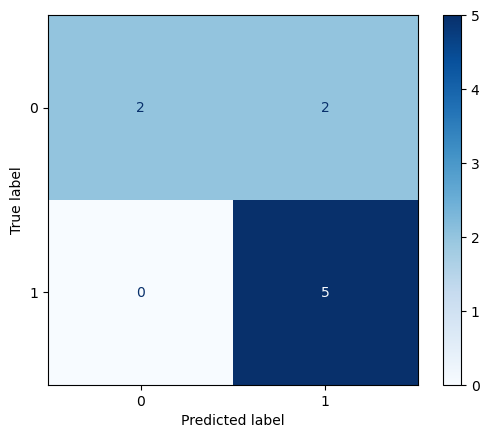

In [195]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(model, X_valid_scaled, y_valid, display_labels=[0,1], cmap="Blues")
plt.show()

The logistic regression predicts a win most of the time. This means that, in practice, the model is more reliable when it predicts a non-win than when it predicts a win

In [196]:
# Coefficients
coef = model.coef_[0]

feature_importance_dict = dict(zip(features, coef))
sorted_features = sorted(feature_importance_dict.items(), key=lambda x: abs(x[1]), reverse=True)
print(sorted_features)

[('Delta_ELO', np.float64(0.2766055871684138))]


Our first attempt at predicting OM victories using logistic regression was insightful:
- Many factors that are generally thought to influence the outcome of a game—such as home/away status, recent goals, or rest days—turned out to be poor predictors for our favorite team during the 2024–2025 season
- Surprisingly, the model performs reasonably well with just two parameters (current form and Elo), offering a good trade-off between performance and complexity

### Second training using decision tree with Random Forest

In [198]:
# Drop the Nan
print(X_OM_2024.isna().sum())
X_OM_2024_clean = X_OM_2024.dropna().copy()
print(X_OM_2024_clean.isna().sum())

Date                              0
Current_form_OM                   0
Current_form_Opponent             0
is_OM_win                         0
ELO OM                            0
ELO Opponent                      0
OM_at_home                        0
OM_goals_scored_last_3_games      1
OM_goals_conceded_last_3_games    1
rest_days_OM                      0
rest_days_Opponent                0
dtype: int64
Date                              0
Current_form_OM                   0
Current_form_Opponent             0
is_OM_win                         0
ELO OM                            0
ELO Opponent                      0
OM_at_home                        0
OM_goals_scored_last_3_games      0
OM_goals_conceded_last_3_games    0
rest_days_OM                      0
rest_days_Opponent                0
dtype: int64


In [199]:
# RandomForestClassifier with all features

from sklearn.ensemble import RandomForestClassifier

features = ['Current_form_OM', 'Current_form_Opponent', 'ELO OM', 'ELO Opponent',
       'OM_at_home', 'OM_goals_scored_last_3_games',
       'OM_goals_conceded_last_3_games','rest_days_OM','rest_days_Opponent']

X = X_OM_2024_clean[features].copy()
y = X_OM_2024_clean['is_OM_win'].copy()

#We split manually the train set and the validation set for defining the different sample in order to avoid training the model with data posterior to the test dataset.
split_index = int(0.75 * len(X_OM_2024_clean))
X_train = X.iloc[:split_index].copy()
X_valid = X.iloc[split_index:].copy()
y_train = y.iloc[:split_index].copy()
y_valid = y.iloc[split_index:].copy()

# Model selection
model = RandomForestClassifier(random_state = 42)

# Model training/fitting
model.fit(X_train, y_train)
y_pred = model.predict(X_valid)
print(model.score(X_valid, y_valid))

importances = model.feature_importances_
feature_importance_dict = dict(zip(features, importances))
print(feature_importance_dict)

0.6666666666666666
{'Current_form_OM': np.float64(0.09984131886799251), 'Current_form_Opponent': np.float64(0.17292117532259746), 'ELO OM': np.float64(0.13264719852817117), 'ELO Opponent': np.float64(0.11177116043036842), 'OM_at_home': np.float64(0.030071567412887856), 'OM_goals_scored_last_3_games': np.float64(0.08894800649455414), 'OM_goals_conceded_last_3_games': np.float64(0.13184433616548777), 'rest_days_OM': np.float64(0.14464049622759076), 'rest_days_Opponent': np.float64(0.08731474055034992)}


In [204]:
# RandomForestClassifier with only the ELO

from sklearn.ensemble import RandomForestClassifier

features = ['ELO OM', 'ELO Opponent']

X = X_OM_2024_clean[features].copy()
y = X_OM_2024_clean['is_OM_win'].copy()

#We split manually the train set and the validation set for defining the different sample in order to avoid training the model with data posterior to the test dataset.
split_index = int(0.75 * len(X_OM_2024_clean))
X_train = X.iloc[:split_index].copy()
X_valid = X.iloc[split_index:].copy()
y_train = y.iloc[:split_index].copy()
y_valid = y.iloc[split_index:].copy()

# Model selection
model = RandomForestClassifier(random_state = 42)

# Model training/fitting
model.fit(X_train, y_train)
y_pred = model.predict(X_valid)
print(f" The score on the training dataset is {model.score(X_train, y_train)}")
print(f" The score on the validation dataset is {model.score(X_valid, y_valid)}")

importances = model.feature_importances_
feature_importance_dict = dict(zip(features, importances))
print(feature_importance_dict)

 The score on the training dataset is 1.0
 The score on the validation dataset is 0.8888888888888888
{'ELO OM': np.float64(0.5184996784431045), 'ELO Opponent': np.float64(0.48150032155689554)}


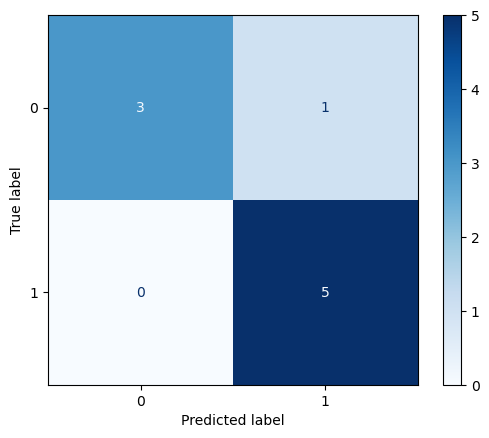

In [205]:
ConfusionMatrixDisplay.from_estimator(model, X_valid, y_valid, display_labels=[0,1], cmap="Blues")
plt.show()

In [206]:
# TO DO:
# Try a model with gradient boosting / XG Boost